# Создание Dilation и Erosion функций и сравнение их работы с готовыми из sci-kit image 

In [1]:
import numpy as np
from skimage.io import imread, imsave, imshow
import skimage.color as color
import skimage.morphology as morphology
import matplotlib.pyplot as plt
from numpy import ogrid
%matplotlib inline

Чтение изображения

In [2]:
img = imread('sample.png')
img = color.rgb2grey(img)

Посмотрим на изображение

(603, 1000)

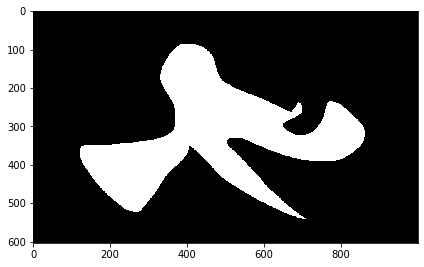

In [3]:
imshow(img)
img.shape

Определим функции для создания нужных нам фигур

In [4]:
def disc_creator(shape, filled=True):
    if shape[0] != shape[1]:
        print('Shape must be an odd square!')
        raise Exception('Shape must be square!')
    fig = np.zeros(shape)
    center = (shape[0] - 1) / 2
    r = center
    rows, cols = ogrid[:fig.shape[0], :fig.shape[1]]
    if filled:
        mask = np.sqrt((rows - center)**2 + (cols - center)**2) <= r
    else:
        mask = np.sqrt((rows - center)**2 + (cols - center)**2) <= r
        mask_1 = r - shape[0] // 100 - 1 <= np.sqrt((rows - center)**2 + (cols - center)**2)
        mask = mask * mask_1
    fig[mask] = 1.
    return fig
    

Функция для обрезания изображения по его границам, для получения более точных результатов

In [5]:
def figure_cutter(figure):    
    shape = figure.shape
    coordinates = [[shape[0], 0], [0,0], [0, shape[1]], [0,0]]  #[[top], [bottom], [left], [right]]
    #print(coordinates[2][1])
    mask = figure == 1.
    for i in range(0, shape[0]):
        for j in range(0, shape[1]):
            if mask[i][j]:
                if coordinates[0][0] >= i:
                    coordinates[0] = [i,j]
                if coordinates[1][0] <= i:
                    coordinates[1] = [i,j]
                if coordinates[2][1] >= j:
                    coordinates[2] = [i,j]
                if coordinates[3][1] <= j:
                    coordinates[3] = [i,j]
    return figure[coordinates[0][0]:coordinates[1][0], coordinates[2][1]:coordinates[3][1]]

In [6]:
def figure_creator(fig_type, shape=(1,1), source=None):
    if shape[0] % 2 == 0 or shape[1] % 2 == 0:
        print('Shape must be odd by any dimension!')
        raise Exception('Shape is not odd!')
    if fig_type == 'rectangle':
        figure = np.full(shape, 1.)
    elif fig_type == 'disc':
        figure = disc_creator(shape)
    elif fig_type == 'ring':
        figure = disc_creator(shape, filled=False)
    elif fig_type == 'custom':
        figure_temp = imread(source)
        figure_temp = color.rgb2grey(figure_temp)
        figure_temp = figure_cutter(figure_temp)
        if figure_temp.shape[0] % 2 == 0:
            figure_temp = figure_temp[0:figure_temp.shape[0] - 1, :]
        if figure_temp.shape[1] % 2 == 0:
            figure_temp = figure_temp[:, 0:figure_temp.shape[1] - 1]
        figure = figure_temp
    else:
        raise Exception('Unsupported figure!')
    return figure

Создадим фигуру из набора или импортируем из файла

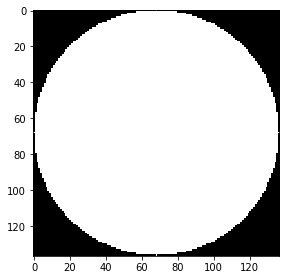

In [7]:
k = figure_creator('disc', (137,137))
imshow(k)
#unique, counts = np.unique(k, return_counts=True)
#dict(zip(unique, counts))

In [8]:
def dilation_custom(img, selem):
    row = img.shape[0] + 2 * selem.shape[0]
    column = img.shape[1] + 2 * selem.shape[1]
    big_img = np.zeros((row, column))
    big_img[selem.shape[0]: row - selem.shape[0], selem.shape[1]:column - selem.shape[1]] = img
    ret_img = np.zeros(big_img.shape)
    mask = big_img == 1.
    selem_mask = selem == 1.
    y_range = selem.shape[0] // 2
    x_range = selem.shape[1] // 2
    for i in range(0, mask.shape[0]):
        for j in range(0, mask.shape[1]):
            if mask[i][j]:
                ret_img[i - y_range: i + y_range + 1, j - x_range: j + x_range + 1][selem_mask] = 1.
    return ret_img[selem.shape[0]:-selem.shape[0], selem.shape[1]:-selem.shape[1]]

In [9]:
def erosion_custom(img, selem):
    row = img.shape[0] + 2 * selem.shape[0]
    column = img.shape[1] + 2 * selem.shape[1]
    big_img = np.zeros((row, column))
    big_img[selem.shape[0]: row - selem.shape[0], selem.shape[1]:column - selem.shape[1]] = img
    ret_img = np.zeros(big_img.shape)
    mask = big_img == 1.
    selem_mask = selem == 1.
    y_range = selem.shape[0] // 2
    x_range = selem.shape[1] // 2
    for i in range(0, mask.shape[0]):
        for j in range(0, mask.shape[1]):
            if mask[i][j] and np.all((mask[i - y_range:i + y_range + 1,j - x_range:j + x_range + 1] * selem_mask) == selem_mask):
                ret_img[i][j] = 1.
    return ret_img[selem.shape[0]:-selem.shape[0], selem.shape[1]:-selem.shape[1]]

Функция для показа двух изображений рядом

In [10]:
def show_couple(im1, im2):
    plt.rcParams["figure.figsize"] = (20,10)
    f, ax = plt.subplots(1, 2)
    ax[0].imshow(im1, cmap='gray')
    ax[1].imshow(im2, cmap='gray')

Сравним работу сделанной мной функции и функции из skimage для dilation

In [11]:
imd = dilation_custom(img, k)
imd_1 = morphology.dilation(img, k)

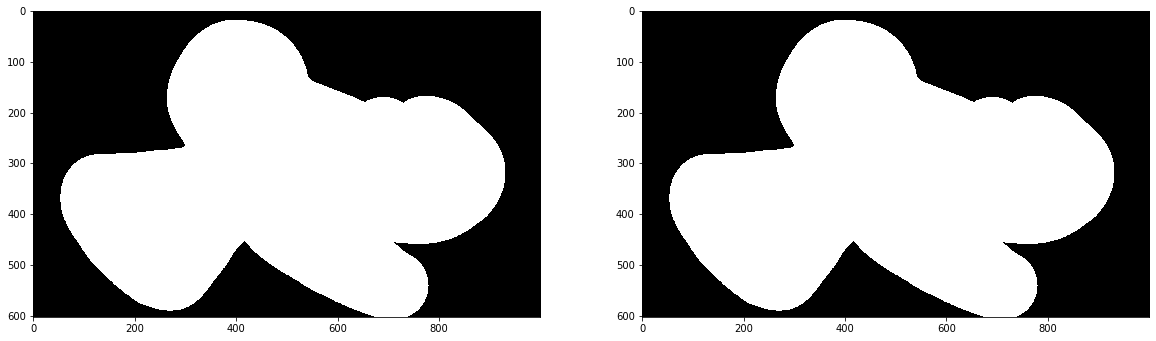

In [12]:
show_couple(imd, imd_1)

Сравним работу сделанной мной функции и функции из skimage для erosion

In [13]:
ime = erosion_custom(img, k)
ime_1 = morphology.erosion(img, k)

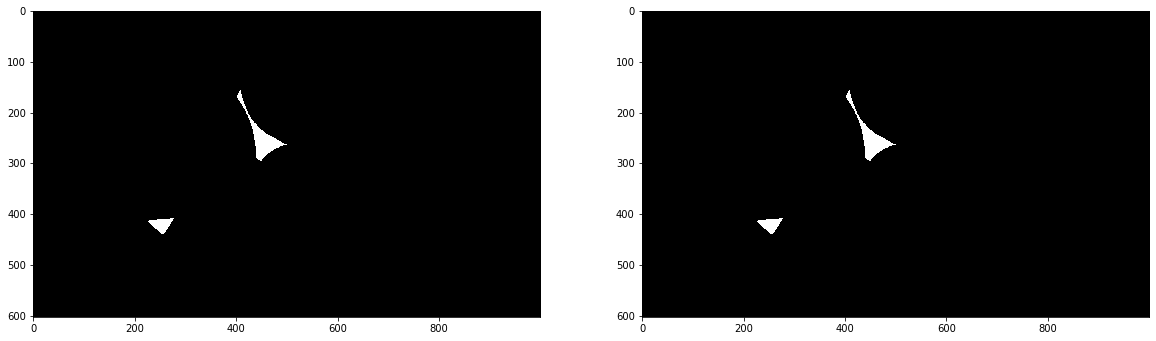

In [14]:
show_couple(ime, ime_1)